<div class="alert alert-block alert-success">
<b>Imported libraries</b>
</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pmd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from fredapi import Fred
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew, kurtosis, shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fred = Fred(api_key = '933bf44f3379eae22b9f6e0340a6e67c')
sns.set_style('white')

<div class="alert alert-block alert-info">
<b>Load the data, set index and info about data</b>
</div>

In [2]:
# Population(Not Seasonally Adjusted)
pop = fred.get_series('POPTHM')
pop.index

DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01'],
              dtype='datetime64[ns]', length=747, freq=None)

<div class="alert alert-block alert-info">
<b>Time series range</b>
</div>

In [3]:
date_real = pd.date_range(start = '1959-01-01', end = '2019-12-01', freq = 'MS')
pop = pop[date_real]

<div class="alert alert-block alert-info">
<b>Data Frame Online or Offline
</div>

In [4]:
p = int(input('0 for Online and anything else for Offline: '))

if p == 0:
    df = pd.DataFrame(pop)
    df.rename(columns = {0: 'value'}, inplace = True)
    df.index.name = 'date'
    df.sort_index(inplace = True)
    df.info()
else:
    df = pd.read_csv('POPTHM.csv')
    df.rename(columns = {'POPTHM': 'value', 'DATE': 'date'}, inplace = True)
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
    # Return an Index of formatted datetime strings
    # df['date'] = df['date'].dt.strftime('%Y/%m/%d')
    df.set_index('date', inplace = True)
    df.sort_index(inplace = True)
    # remove 2020-01
    df.drop(df.tail(1).index, inplace = True)
    df.info()

0 for Online and anything else for Offline: 1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 1959-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   732 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


<div class="alert alert-block alert-info">
<b>Plot original time series</b>
</div>

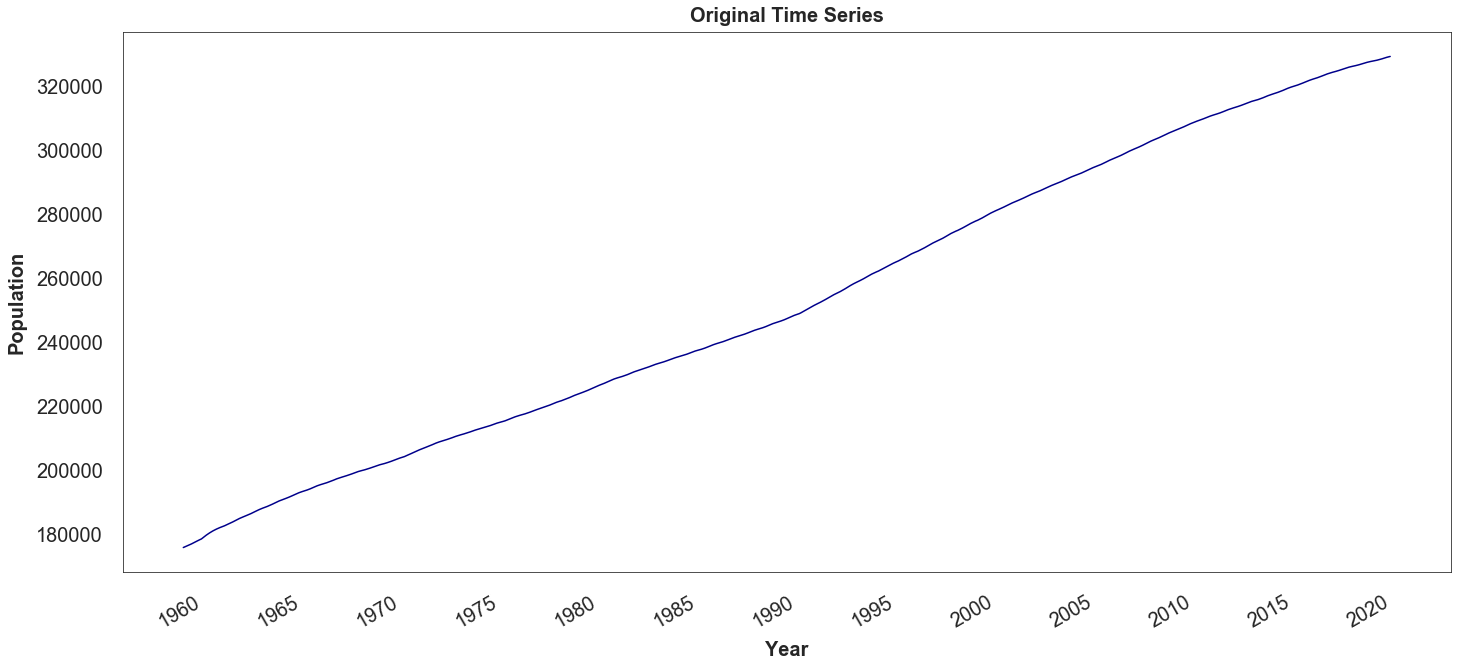

In [5]:
plt.figure(figsize = (20,10))
plt.title('Original Time Series', weight = 'bold', fontsize = 20, pad = 10)
plt.xlabel('Year', weight = 'bold', fontsize = 20, labelpad = 10)
plt.ylabel('Population', weight = 'bold', fontsize = 20,  labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(axis = 'both', pad = 10, size = 10)                                
plt.tight_layout()                                               
plt.plot(df.index, df['value'], color = 'darkblue')
plt.gcf().autofmt_xdate()
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5)) 
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

<div class="alert alert-block alert-info">
<b>Pick a year to plot</b>
</div>

Type the year you want to plot from 1959 to 2019: 2000


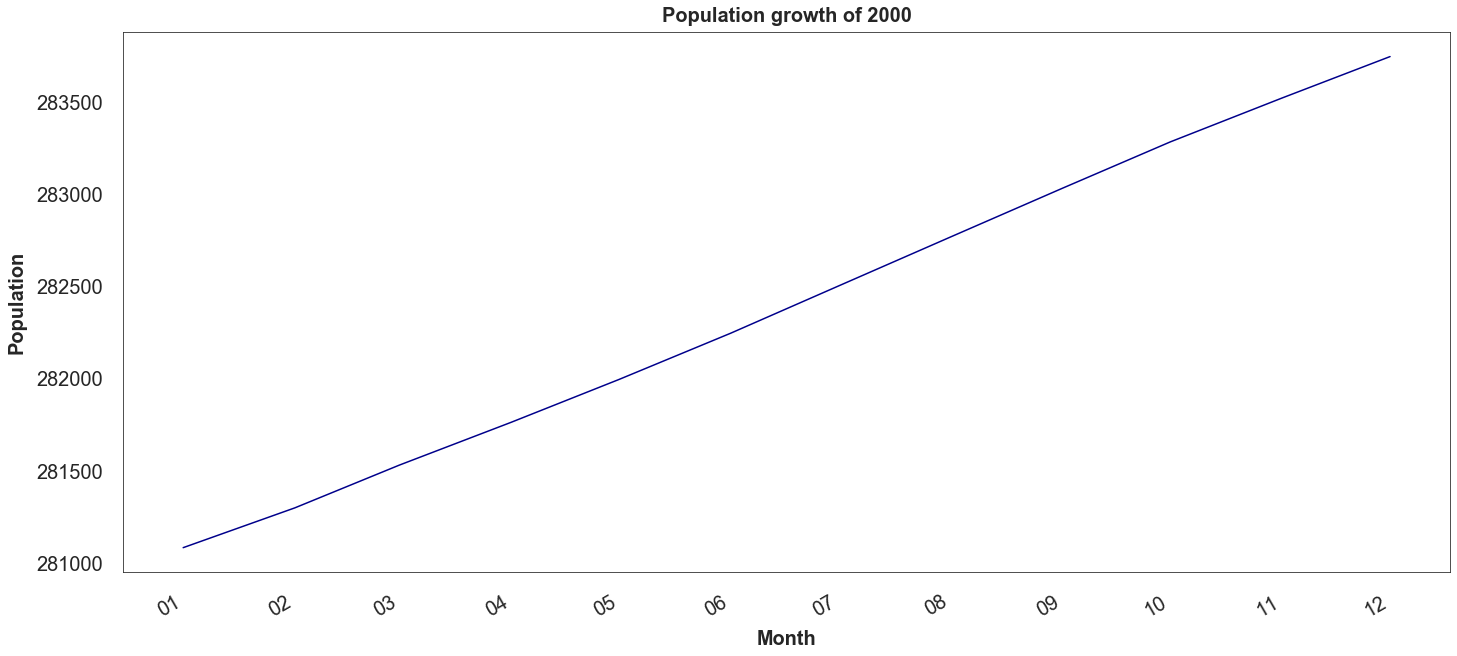

In [6]:
year = int(input('Type the year you want to plot from 1959 to 2019: '))
if year > 1958 and year < 2020:
    plt.figure(figsize = (20,10))
    plt.title('Population growth of %.0f' % year, weight = 'bold', fontsize = 20, pad = 10)
    plt.xlabel('Month', weight = 'bold', fontsize = 20, labelpad = 10)
    plt.ylabel('Population', weight = 'bold', fontsize = 20,  labelpad = 10)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.tick_params(axis = 'both', pad = 10, size = 10)                                
    plt.tight_layout()                                                                                                                                  
    dfyear1 = df[df.index.year == year]
    plt.plot(dfyear1.index, dfyear1['value'],color = 'darkblue')
    plt.gcf().autofmt_xdate()
    date_format = mdates.DateFormatter('%m')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval = 1)) 
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.show()
else:
    print('Run again and type a valid year')

<div class="alert alert-block alert-info">
<b>Pick multiple years to plot</b>
</div>

Type the year you wanna start from 1959 to 2018: 2010
Type the year you wanna stop from 1960 to 2019: 2019


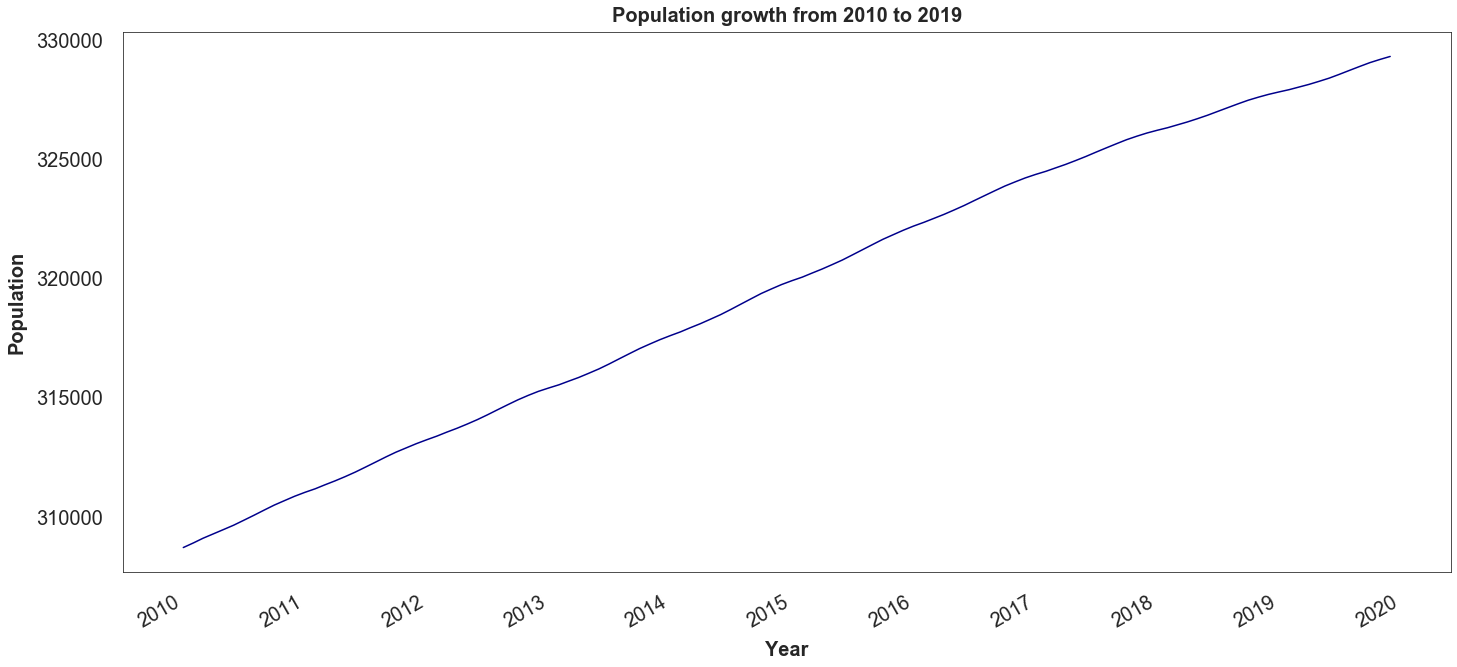

In [7]:
year_s = int(input('Type the year you wanna start from 1959 to 2018: '))
year_p = int(input('Type the year you wanna stop from 1960 to 2019: '))
if year_s > 1958 and year_s < year_p and year_p > year_s and year_p < 2020:
    plt.figure(figsize = (20,10))
    plt.title('Population growth from %.0f to %.0d' % (year_s, year_p), weight = 'bold', fontsize = 20, pad = 10)
    plt.xlabel('Year', weight = 'bold', fontsize = 20, labelpad = 10)
    plt.ylabel('Population', weight = 'bold', fontsize = 20, labelpad = 10)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.tick_params(axis = 'both', pad = 10, size = 10)                                  
    plt.tight_layout()                                               
    dfyear2 = df[(df.index.year >= year_s) & (df.index.year <= year_p)]
    plt.plot(dfyear2.index, dfyear2['value'], color = 'darkblue')
    plt.gcf().autofmt_xdate()
    date_format = mdates.DateFormatter('%Y')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1)) 
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.show()
else:
    print('Run again and type a valid year(s)')

<div class="alert alert-block alert-info">
<b>Create percentage change time series</b>
</div>

In [8]:
# Get percentage change and drop na values
pct_fix = df['value'].pct_change().dropna()

<div class="alert alert-block alert-info">
<b>Kolmogorov-Smirnov Test</b>
</div>

In [9]:
%%capture --no-stdout

list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr',
                 'burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang',
                 'expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk',
                 'foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto',
                 'gennorm','genexpon','genextreme','gausshyper','gamma','gengamma',
                 'genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy',
                 'halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss',
                 'invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l',
                 'logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke',
                 'nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw',
                 'powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice',
                 'recipinvgauss','semicircular','t','triang','truncexpon','truncnorm',
                 'tukeylambda','uniform','vonmises','vonmises_line','wald',
                 'weibull_min','weibull_max']
    
results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(pct_fix)
    a = stats.kstest(pct_fix, i, args = param)
    results.append((i, a[0], a[1]))
    
results.sort(key = lambda x:float(x[2]), reverse = True)
for j in results:
    if j[2] > 0.9:
        print("{}: statistic = {}, pvalue = {}".format(j[0], j[1], j[2]))

genlogistic: statistic = 0.018054021152807354, pvalue = 0.9710351430519097
exponnorm: statistic = 0.018455029654836003, pvalue = 0.9646009127227381
johnsonsu: statistic = 0.01958421827356216, pvalue = 0.9418955360952449
burr12: statistic = 0.02065647482580435, pvalue = 0.9140377145895563


<div class="alert alert-block alert-info">
<b>Normal Q-Q plot and Shapiro-Wilk Test</b>
</div>

Statistic: 0.942
p-value: 0.000

Null hypothesis of normality is rejected


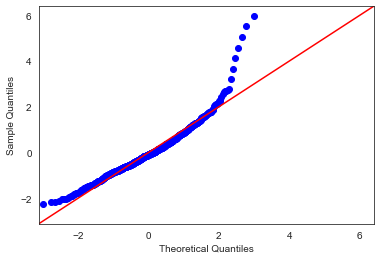

In [10]:
normal = shapiro(pct_fix)
print('Statistic: %.3f' % (normal[0]))
print('p-value: %.3f\n' % (normal[1]))
if normal[1] <= 0.05:
    print('Null hypothesis of normality is rejected')
else:
    print('Null hypothesis of normality is accepted')

sm.qqplot(pct_fix, stats.norm, fit = True, line = '45') 
plt.show()

<div class="alert alert-block alert-info">
<b>Generalized Logistic Distribution Q-Q plot</b>
</div>

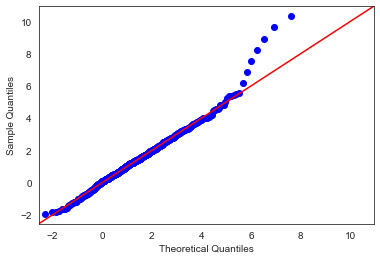

In [11]:
sm.qqplot(pct_fix, stats.genlogistic, fit = True, line = '45') 
plt.show()

<div class="alert alert-block alert-info">
<b>Probability density function (PDF)</b>
</div>

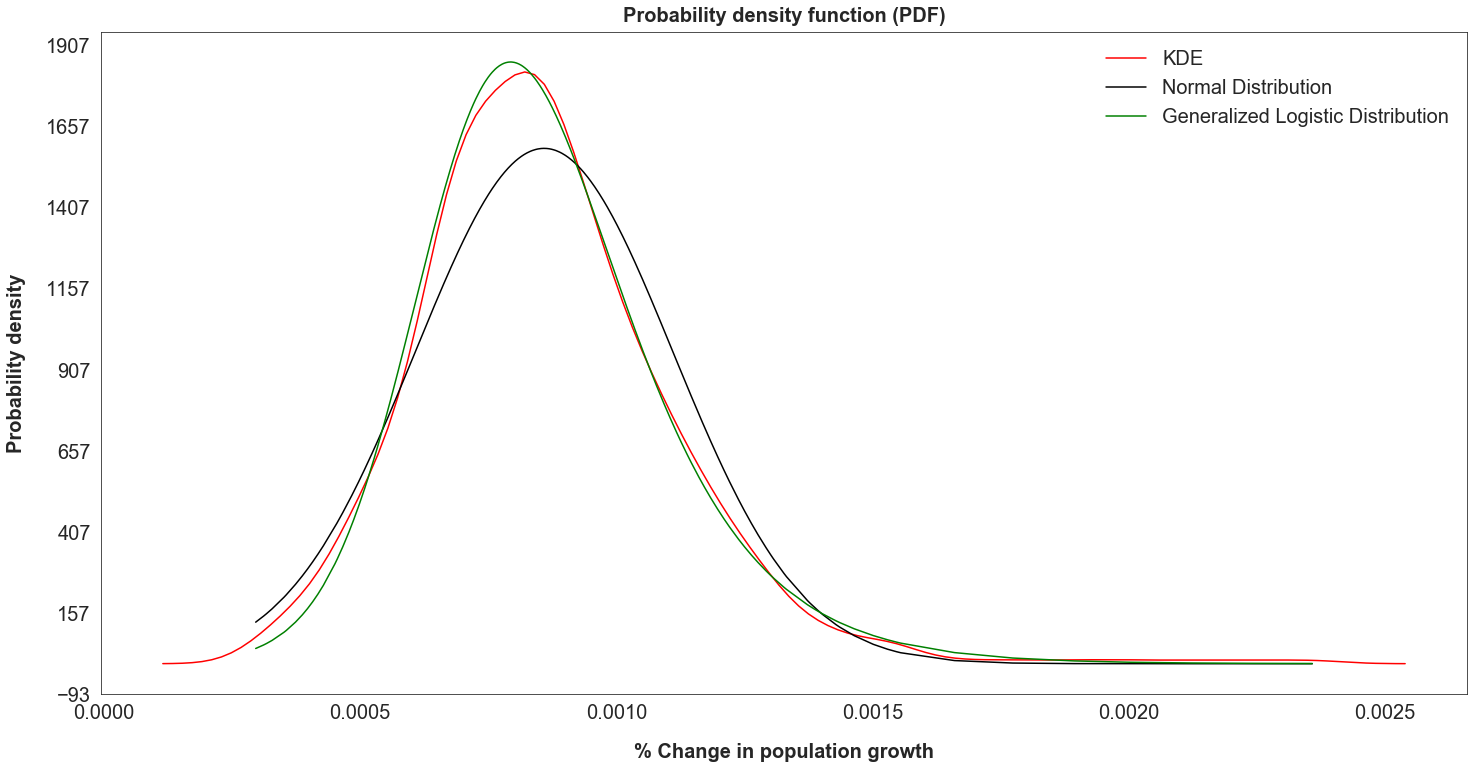

In [12]:
plt.figure(figsize = (20,10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(axis = 'both', length = 0, pad = 10)  
plt.tight_layout()    

ax = sns.kdeplot(pct_fix, color = 'red', label = 'KDE')

# Fitting Normal Distribution, same as fit = stats.norm
parameters_norm = stats.norm.fit(pct_fix)
# Parameters
mean_norm, std_norm = parameters_norm
norm_pdf = norm.pdf(pct_fix, mean_norm, std_norm)
ax = sns.lineplot(pct_fix, norm_pdf, color = 'black', 
                  label = 'Normal Distribution')

# Fitting Generalized Logistic Distribution, same as fit = stats.genlogistic
parameters_genlogistic = stats.genlogistic.fit(pct_fix)
# Parameters
c, mean_genlogistic, std_genlogistic = parameters_genlogistic
genlogistic_pdf = stats.genlogistic.pdf(pct_fix, c, mean_genlogistic, std_genlogistic)
ax = sns.lineplot(pct_fix, genlogistic_pdf, color = 'green', 
                  label = 'Generalized Logistic Distribution')

ax.set_title('Probability density function (PDF)', weight = 'bold', fontsize = 20, pad = 10)
ax.set_xlabel('% Change in population growth', weight = 'bold', fontsize = 20, labelpad = 20)
ax.set_ylabel('Probability density', weight = 'bold', fontsize = 20, labelpad = 20)
start, end = plt.ylim()
plt.yticks(np.arange(start, end, 250))
plt.legend(loc = 'best', prop = {'size':20}, frameon = False)
plt.show()

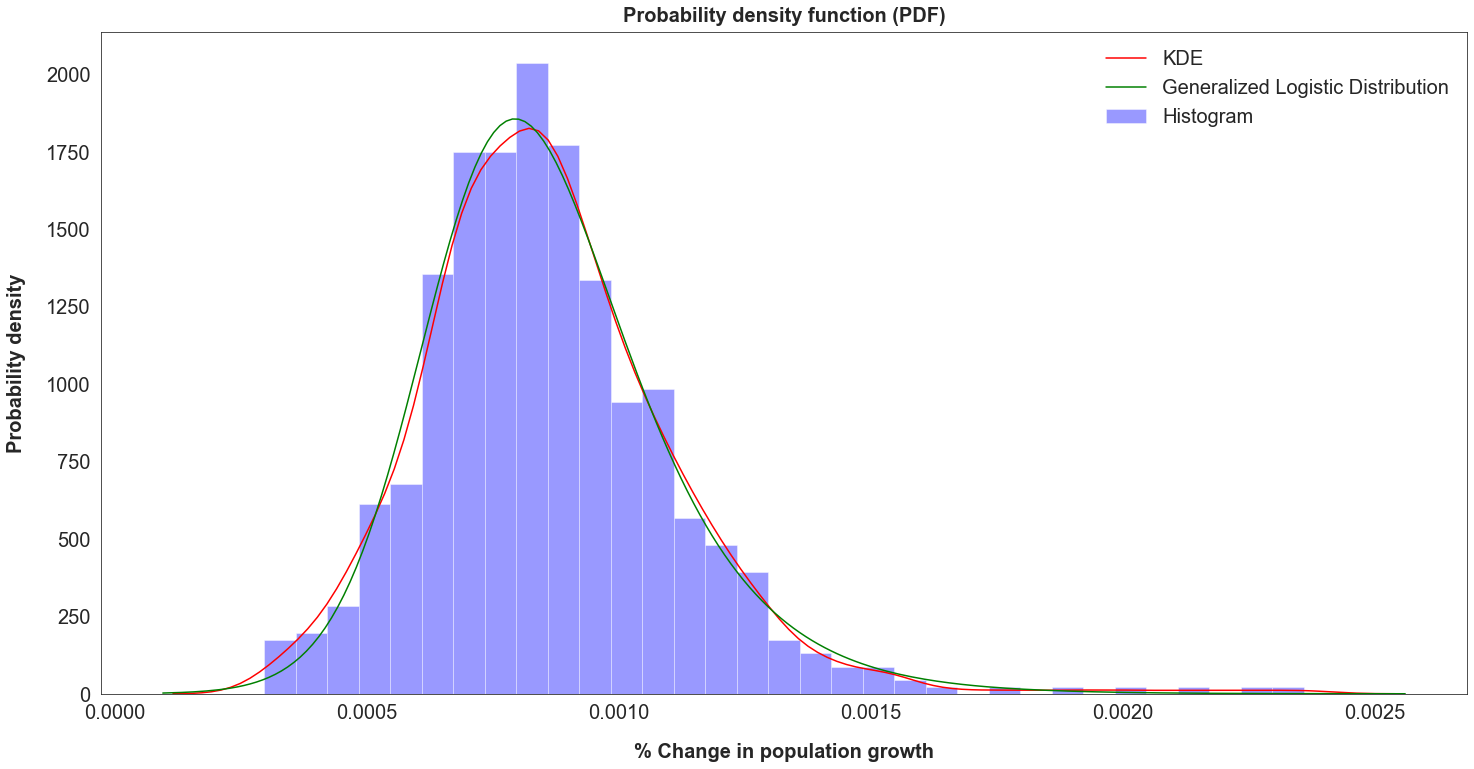

Skewness: 1.186099
Kurtosis: 4.239317


In [13]:
plt.figure(figsize = (20,10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(axis = 'both', length = 0, pad = 10)  
plt.tight_layout()                                               

# Getting the Histogram format, KDE and fitting distribution, this is the PDF
ax = sns.distplot(pct_fix, 
                  kde_kws = {'shade': False, 'color': 'r', 'label': 'KDE'}, 
                  fit = stats.genlogistic, 
                  fit_kws = {'color': 'g', 'label': 'Generalized Logistic Distribution'},
                  hist = True, color = 'blue', label = 'Histogram')

ax.set_title('Probability density function (PDF)', weight = 'bold', fontsize = 20, pad = 10)
ax.set_xlabel('% Change in population growth', weight = 'bold', fontsize = 20, labelpad = 20)
ax.set_ylabel('Probability density', weight = 'bold', fontsize = 20, labelpad = 20)
start, end = plt.ylim()
plt.yticks(np.arange(start, end, 250))
plt.legend(loc = 'best', prop = {'size':20}, frameon = False)
plt.show()

print('Skewness: %f' % skew(pct_fix)) 
print('Kurtosis: %f' % kurtosis(pct_fix))

<div class="alert alert-block alert-info">
<b>Check if the time series of original and percentage change values are stationary</b>
</div>

In [14]:
result = adfuller(df['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]['5%']:
    print ('Reject Ho - Time Series is Stationary')
else:
    print ('Failed to Reject Ho - Original Time Series is Non-Stationary')

ADF Statistic: 0.221052
p-value: 0.973418
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Failed to Reject Ho - Original Time Series is Non-Stationary


In [15]:
result = adfuller(pct_fix)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]['5%']:
    print ('Reject Ho - Percentage change Time Series is Stationary')
else:
    print ('Failed to Reject Ho - Percentage change Time Series is Non-Stationary')

ADF Statistic: -3.551020
p-value: 0.006769
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Reject Ho - Percentage change Time Series is Stationary


<div class="alert alert-block alert-info">
<b>Decomposition of percentage change time series</b>
</div>

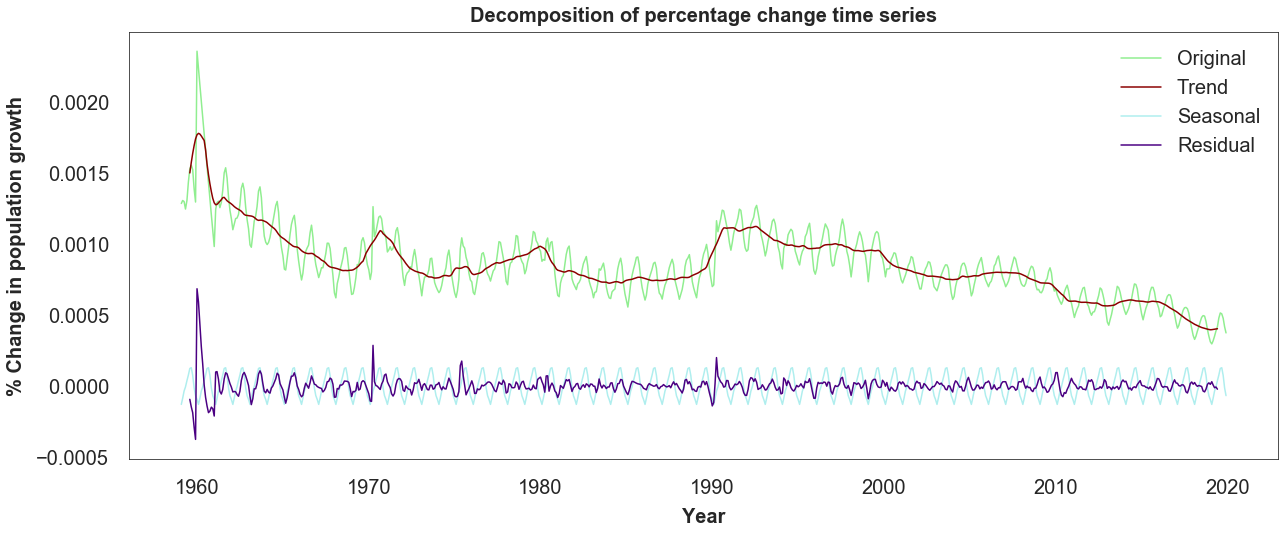

In [16]:
# Decomposition of percentage change time series
decomposition = seasonal_decompose(pct_fix)
# Trend of percentage change time series
trend = decomposition.trend
# Seasonal of percentage change time series
seasonal = decomposition.seasonal
# Residual of percentage change time series
residual = decomposition.resid

plt.figure(figsize = (20,10))
plt.title('Decomposition of percentage change time series', weight = 'bold', fontsize = 20, pad = 10)
plt.xlabel('Year', weight = 'bold', fontsize = 20, labelpad = 10)
plt.ylabel('% Change in population growth', weight = 'bold', fontsize = 20, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(axis = 'both', pad = 10, size = 10)                                  
plt.tight_layout(pad = 10)                                               
plt.rc('font', size = 10)
plt.rc('font', weight = 'normal')
plt.plot(pct_fix, label = 'Original', color = 'lightgreen')
plt.plot(trend, label = 'Trend', color = 'darkred')
plt.plot(seasonal, label = 'Seasonal', color = 'paleturquoise')
plt.plot(residual, label = 'Residual', color = 'indigo')
plt.legend(loc = 'upper right', prop = {'size':20}, frameon = False)
plt.show()

<div class="alert alert-block alert-info">
<b>Plotting Autocorrelation and Parial Autocorrelation</b>
</div>

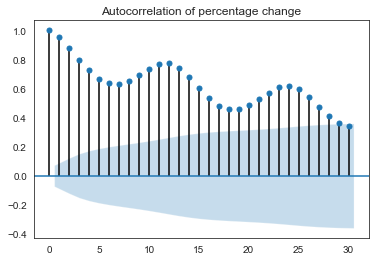

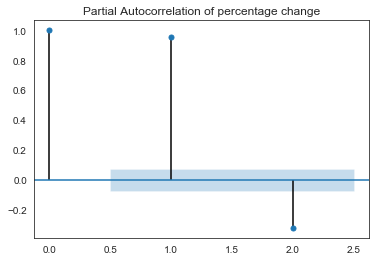

In [17]:
acf_diff = plot_acf(pct_fix, title = 'Autocorrelation of percentage change', lags = 30)

pacf_diff = plot_pacf(pct_fix,  title = 'Partial Autocorrelation of percentage change', lags = 2)

<div class="alert alert-block alert-info">
<b>Create train and test data split</b>
</div>

In [18]:
y = pct_fix
y_train, y_test = train_test_split(y, test_size = 0.2, shuffle = False)

<div class="alert alert-block alert-info">
<b>Auto Arima Function</b>
</div>

In [19]:
def arimamodel(timeseries):
    autoarima_model = pmd.auto_arima(timeseries, 
                              start_p = 1,
                              start_q = 1,
                              trace = True,
                              error_action = 'ignore',
                              suppress_warnings = True,
                              stepwise = False)
    return autoarima_model

<div class="alert alert-block alert-info">
<b>Model</b>
</div>

In [20]:
arima_model = arimamodel(y_train)
arima_model.summary()

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-9335.945, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=nan, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-9382.705, Time=0.46 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-9360.457, Time=0.65 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-9383.231, Time=0.43 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-9378.643, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-9325.336, Time=0.95 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-9384.916, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-8969.372, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-9322.977, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-9323.340, Time=1.00 sec
 ARIMA(3,1,0)(0,0,0)[1] inter

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(5, 1, 0)   Log Likelihood                4717.283
Date:                Tue, 04 May 2021   AIC                          -9420.567
Time:                        05:22:37   BIC                          -9389.990
Sample:                             0   HQIC                         -9408.649
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.117e-06   3.83e-06     -0.292      0.770   -8.62e-06    6.39e-06
ar.L1          0.2595   5.06e-10   5.13e+08      0.000       0.259       0.259
ar.L2         -0.0379   5.46e-11  -6.95e+08      0.000      -0.038      -0.038
ar.L3         -0.0085   7.24e-11  -1.17e+08      0.000      -0.008      -0.008
ar.L4         -0.1114   5.04e-11  -2.21e+09      0.000      -0.111      -0.111
ar.L5         -0.1986   1.44e-11  -1.38e+10      0.000      -0.199      -0.199
sigma2      5.486e-09   6.47e-11     84.856      0.000    5.36e-09    5.61e-09
===================================================================================
Ljung-Box (Q):                      235.40   Jarque-Bera (JB):            184570.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             5.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        89.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.73e+26. Standard errors may be unstable.
"""

In [21]:
y_test.index

DatetimeIndex(['2007-10-01', '2007-11-01', '2007-12-01', '2008-01-01',
               '2008-02-01', '2008-03-01', '2008-04-01', '2008-05-01',
               '2008-06-01', '2008-07-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=147, freq=None)

In [22]:
date_predict = pd.date_range(start = '2007-11-01', end = '2025-12-01', freq = 'MS')

In [23]:
model_data = arima_model.predict(n_periods = date_predict.size, 
                                return_conf_int = True, alpha = 0.05)

forecasted = model_data[0]
lower_conf = np.hsplit(model_data[1], 2)[0].reshape(date_predict.size, 1).flatten()
upper_conf = np.hsplit(model_data[1], 2)[1].reshape(date_predict.size, 1).flatten()

In [24]:
# The two months before 
date_2020 = pd.date_range(start = '2019-11-01', end = '2020-12-01', freq = 'MS')
pop_2020 = pop[date_2020]

In [25]:
df_2020 = pd.DataFrame(pop_2020)
df_2020.rename(columns = {0: 'value'}, inplace = True)
df_2020.index.name = 'date'
pct_fix = df_2020['value'].pct_change()
df_2020['value'] = pct_fix
df_2020.sort_index(inplace = True)
df_2020 = df_2020.dropna()
df_2020.head()

,value
date,
2019-12-01,0.000374
2020-01-01,0.000000
2020-02-01,0.000000
2020-03-01,0.000000
2020-04-01,0.000000


In [26]:
df2 = pd.DataFrame()
df2['predict_date'] = date_predict
# To transform in a series if needed pd.Series()
df2['forecasted'] = forecasted 
df2['lower_conf'] = lower_conf
df2['upper_conf'] = upper_conf
df2.set_index('predict_date', inplace = True)
df2 = df2[['lower_conf', 'forecasted', 'upper_conf']]
df2.tail()

,lower_conf,forecasted,upper_conf
predict_date,,,
2025-08-01,-0.001320,0.000630,0.002579
2025-09-01,-0.001326,0.000629,0.002583
2025-10-01,-0.001331,0.000628,0.002586
2025-11-01,-0.001336,0.000627,0.002590
2025-12-01,-0.001342,0.000626,0.002593


<div class="alert alert-block alert-info">
<b>Forecast Plot</b>
</div>

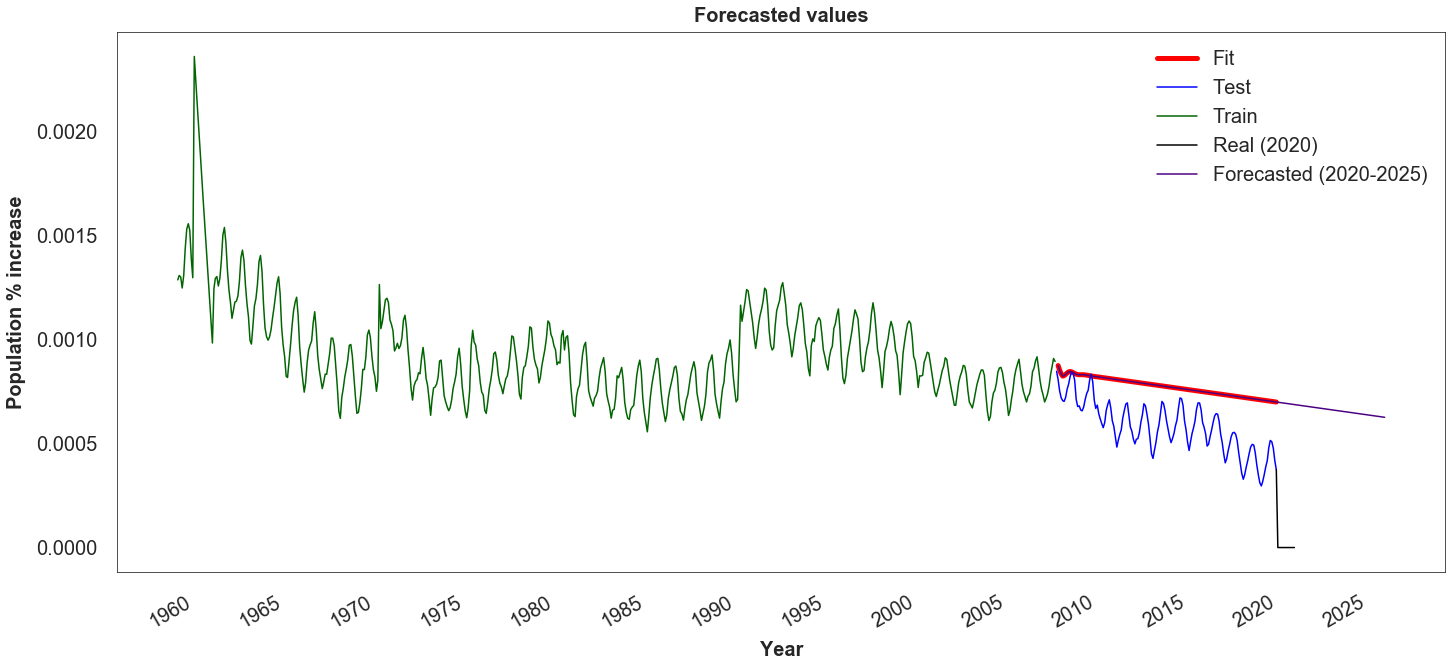

In [27]:
plt.figure(figsize = (20,10))
plt.title('Forecasted values', weight = 'bold', fontsize = 20, pad = 10)
plt.xlabel('Year', weight = 'bold', fontsize = 20, labelpad = 10)
plt.ylabel('Population % increase', weight = 'bold', fontsize = 20, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(axis = 'both', pad = 10, size = 10)                                  
plt.tight_layout()              
plt.plot(df2['forecasted'][y_test.index], label = 'Fit', color = 'red', linewidth = 5)
plt.plot(y_test, label = 'Test', color = 'blue')
plt.plot(y_train, label = 'Train', color = 'darkgreen')
plt.plot(df_2020['value'][df_2020.index], label = 'Real (2020)', color = 'black')
plt.plot(df2['forecasted'][df2.index], label = 'Forecasted (2020-2025)', color = 'indigo')
plt.legend(loc = 'best', prop = {'size':20}, frameon = False)
plt.gcf().autofmt_xdate()
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5)) 
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

<div class="alert alert-block alert-info">
<b>Confidence Interval Plot</b>
</div>

In [28]:
date_forecast = pd.date_range(start = '2020-02-01', end = '2025-12-01', freq = 'MS')

<Figure size 432x288 with 0 Axes>

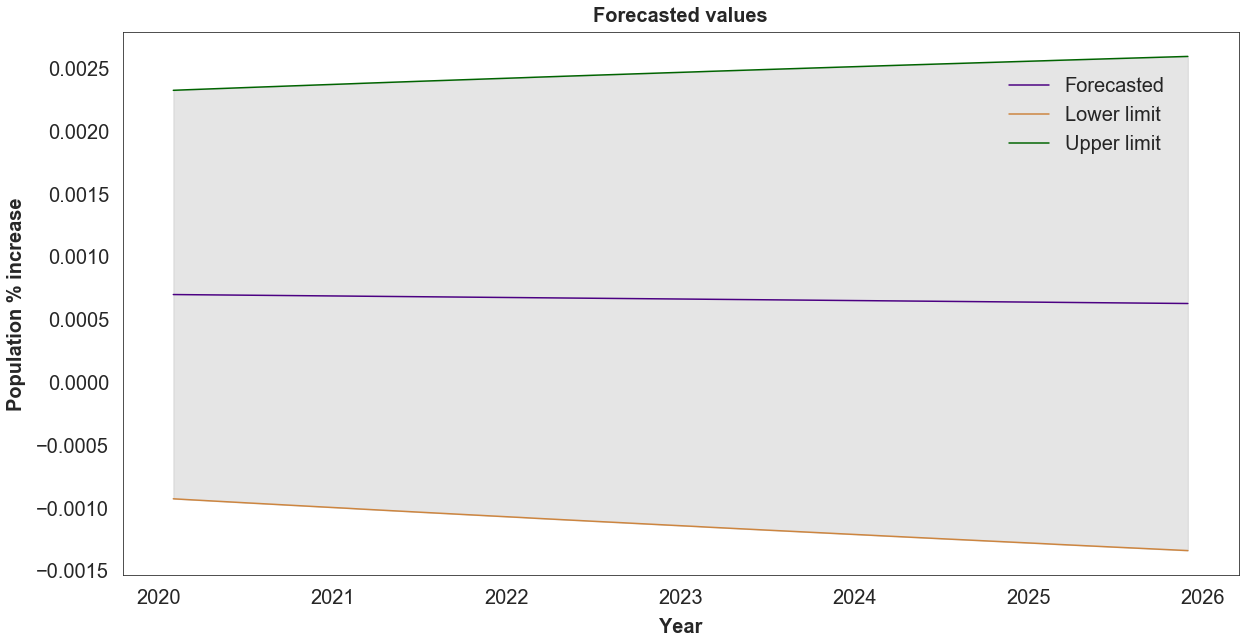

In [29]:
plt.tight_layout()     
plt.figure(figsize = (20,10))
plt.title('Forecasted values', weight = 'bold', fontsize = 20, pad = 10)
plt.xlabel('Year', weight = 'bold', fontsize = 20, labelpad = 10)
plt.ylabel('Population % increase', weight = 'bold', fontsize = 20, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(axis = 'both', pad = 10, width = 0)                                                                               
plt.plot(df2['forecasted'][date_forecast], label = 'Forecasted', color = 'indigo')
plt.plot(df2['lower_conf'][date_forecast], label = 'Lower limit', color = 'peru')
plt.plot(df2['upper_conf'][date_forecast], label = 'Upper limit', color = 'darkgreen')
plt.fill_between(date_forecast, df2['lower_conf'][date_forecast], 
                 df2['upper_conf'][date_forecast], color = 'black', alpha = 0.1)
plt.legend(bbox_to_anchor = (0.95, 0, 0, 0.95), prop = {'size':20}, frameon = False)
plt.show()